In [1]:
%matplotlib inline

import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
tf.autograph.set_verbosity(0, True)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization)

import matplotlib.pyplot as plt
import seaborn as sns
from utils4t import MultipleTimeSeriesCV, format_time

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [2]:
np.random.seed(1)
tf.random.set_seed(1)
sns.set_style('whitegrid')

results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [1]:
prices = (pd.read_hdf('data/assets.h5', 'quandl/wiki/prices').adj_close.unstack().loc['2000':])
prices.info()

NameError: name 'pd' is not defined

In [13]:
prices.sample(10)

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2005-11-17,23.714686,NaN,89.175101,NaN,11.747392,NaN,2.783662,38.449073,8.291719,NaN,...,4.50,2.010,27.680,NaN,60.912580,NaN,NaN,12.2800,NaN,19.095
2016-04-14,40.185522,NaN,40.564623,19.865,26.841389,16.25,27.274687,160.508875,108.888277,36.973433,...,8.62,3.890,NaN,29.80,NaN,2.43,37.55,NaN,47.209526,17.520
2011-11-18,25.113280,NaN,11.484672,NaN,24.317099,NaN,8.852927,67.055848,48.185016,17.609343,...,4.49,2.750,3.540,13.90,46.849879,NaN,NaN,3.0500,NaN,23.000
2015-07-30,40.031273,NaN,39.388271,132.000,35.561110,18.56,22.006493,171.885339,117.192056,38.900830,...,12.90,4.910,NaN,32.11,NaN,2.47,44.98,0.4833,47.709097,26.510
2003-07-29,14.968361,NaN,NaN,NaN,7.486043,NaN,3.082889,21.466683,1.331404,NaN,...,NaN,3.671,23.390,NaN,47.149703,NaN,NaN,8.7500,NaN,NaN
2011-10-11,23.148426,NaN,15.174318,NaN,25.997190,NaN,7.410973,60.147961,51.442844,14.718257,...,4.40,2.770,2.810,NaN,52.033928,NaN,NaN,3.2000,NaN,21.910
2004-01-16,23.366743,NaN,NaN,NaN,8.611868,NaN,3.766835,26.644784,1.459918,NaN,...,NaN,12.570,26.015,NaN,73.650253,NaN,NaN,8.9700,NaN,NaN
2012-08-03,26.810531,NaN,28.295946,NaN,29.230963,NaN,7.934484,67.277502,79.126031,22.833280,...,5.26,2.460,3.020,4.94,57.411186,2.72,NaN,2.8100,NaN,33.870
2014-02-27,39.232935,NaN,35.433279,800.000,30.425170,19.20,19.102210,124.237149,70.556622,30.239862,...,4.58,4.530,21.710,20.55,94.083562,5.21,NaN,7.7900,29.883807,23.350


In [4]:
# Compute monthly returns
returns = (prices.resample('M').last().pct_change().dropna(how='all').loc['2000': '2017'].dropna(axis=1)
           .sort_index(ascending=False))

# remove outliers likely representing data errors
returns = returns.where(returns<1).dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2017-12-31 to 2000-02-29
Freq: -1M
Columns: 1511 entries, A to ZQK
dtypes: float64(1511)
memory usage: 2.5 MB


In [15]:
pd.concat([returns.head(), returns.tail()])

ticker,A,AAN,AAON,AAPL,ABAX,ABC,ABCB,ABFS,ABM,ABMD,...,Y,YHOO,YORW,YUM,ZAZA,ZBRA,ZEUS,ZION,ZLC,ZQK
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,-0.032785,0.056469,0.006859,-0.015246,0.016003,0.082528,-0.028226,0.000000,-0.118692,-0.038134,...,0.019306,0.000000,-0.087483,-0.022283,0.000000,-0.059101,0.078815,0.025832,0.000000,0.000000
2017-11-30,0.017786,0.025000,0.041429,0.016623,0.007025,0.107587,0.035491,0.000000,0.019776,0.009952,...,0.032814,0.000000,0.055398,0.121155,0.000000,-0.048884,0.055085,0.066509,0.000000,0.000000
2017-10-31,0.061814,-0.156544,0.015228,0.096808,0.083987,-0.070091,-0.001043,0.000000,0.010211,0.144247,...,0.022039,0.000000,0.038348,0.011411,0.000000,0.068245,-0.141818,-0.015261,0.000000,0.000000
2017-09-30,-0.008035,-0.013832,0.057515,-0.060244,-0.033968,0.031153,0.090808,0.000000,-0.061220,0.118037,...,-0.015566,0.000000,0.035079,-0.041786,0.000000,0.053254,0.205479,0.080623,0.000000,0.000000
2017-08-31,0.082455,-0.043431,-0.035503,0.106251,-0.013579,-0.140733,-0.038210,0.000000,-0.004258,0.018300,...,-0.082450,0.000000,-0.054598,0.017753,0.000000,0.013468,0.069057,-0.034067,0.000000,0.000000
2000-06-30,0.001630,0.024918,0.004922,0.247143,0.009509,0.279175,-0.013397,-0.096364,-0.008193,-0.190789,...,0.010526,0.076455,0.016690,-0.036165,0.000000,-0.076875,-0.211356,-0.003691,-0.039474,0.141599
2000-05-31,-0.169243,-0.011010,0.160952,-0.322908,-0.070175,0.212500,0.000000,-0.149923,-0.081584,0.023431,...,-0.013704,-0.116654,0.016949,-0.134888,-0.045455,-0.157895,-0.065684,0.115261,-0.078788,-0.278072
2000-04-30,-0.147788,-0.098131,0.195900,-0.086518,-0.149254,0.333333,-0.018390,0.232381,0.081537,-0.083210,...,-0.103404,-0.239790,0.043878,0.090792,0.000000,0.140000,0.187500,-0.003123,-0.125874,0.075171
2000-03-31,0.000962,-0.021714,0.029308,0.184872,0.038695,0.030220,0.028922,0.112288,-0.067090,-0.452259,...,0.011079,0.073262,-0.089186,0.166354,-0.185185,-0.248798,-0.111111,-0.215417,0.254386,0.377255


In [5]:
# Create model data
n = len(returns)
nlags = 12
lags = list(range(1, nlags + 1))
cnn_data = []
for i in range(n-nlags-1):
    df = returns.iloc[i:i+nlags+1]        # select outcome and lags
    date = df.index.max()                 # use outcome date
    cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
                    .assign(date=date).set_index('date', append=True).sort_index(1, ascending=True))

cnn_data = (pd.concat(cnn_data).rename(columns={0: 'label'}).sort_index())

cnn_data.info(null_counts=True)

C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # appen

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305222 entries, ('A', Timestamp('2001-03-31 00:00:00')) to ('ZQK', Timestamp('2017-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   305222 non-null  float64
 1   1       305222 non-null  float64
 2   2       305222 non-null  float64
 3   3       305222 non-null  float64
 4   4       305222 non-null  float64
 5   5       305222 non-null  float64
 6   6       305222 non-null  float64
 7   7       305222 non-null  float64
 8   8       305222 non-null  float64
 9   9       305222 non-null  float64
 10  10      305222 non-null  float64
 11  11      305222 non-null  float64
 12  12      305222 non-null  float64
dtypes: float64(13)
memory usage: 31.5+ MB


C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # append transposed series
C:\Users\19498\AppData\Local\Temp\ipykernel_20932\425695846.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  cnn_data.append(df.reset_index(drop=True).transpose()  # appen

In [17]:
pd.concat([cnn_data.head(), cnn_data.tail()])

label         1         2         3         4         5  \
ticker date                                                                     
A      2001-03-31 -0.146389 -0.340055 -0.003653  0.049052  0.126970 -0.053739   
       2001-04-30  0.269444 -0.146389 -0.340055 -0.003653  0.049052  0.126970   
       2001-05-31 -0.140220  0.269444 -0.146389 -0.340055 -0.003653  0.049052   
       2001-06-30 -0.031008 -0.140220  0.269444 -0.146389 -0.340055 -0.003653   
       2001-07-31 -0.119692 -0.031008 -0.140220  0.269444 -0.146389 -0.340055   
ZQK    2017-08-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-09-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-10-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-11-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-12-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                          6         7         8         9        10        11  \
ticker date                                                                     
A      2001-03-31 -0.197705  0.496933 -0.447458  0.001630 -0.169243 -0.147788   
       2001-04-30 -0.053739 -0.197705  0.496933 -0.447458  0.001630 -0.169243   
       2001-05-31  0.126970 -0.053739 -0.197705  0.496933 -0.447458  0.001630   
       2001-06-30  0.049052  0.126970 -0.053739 -0.197705  0.496933 -0.447458   
       2001-07-31 -0.003653  0.049052  0.126970 -0.053739 -0.197705  0.496933   
ZQK    2017-08-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-09-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-10-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-11-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-12-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                         12  
ticker date                  
A      2001-03-31  0.000962  
       2001-04-30 -0.147788  
       2001-05-31 -0.169243  
       2001-06-30  0.001630  
       2001-07-31 -0.447458  
ZQK    2017-08-31  0.000000  
       2017-09-30  0.000000  
       2017-10-31  0.000000  
       2017-11-30  0.000000  
       2017-12-31  0.000000

In [6]:
# Evaluate features

# Mutual Information
# mi = mutual_info_regression(X=cnn_data.drop('label', axis=1), y=cnn_data.label)
# mi = pd.Series(mi, index=cnn_data.drop('label', axis=1).columns)

# Information Coefficient
# ic = {}
# for lag in lags:
#     ic[lag] = spearmanr(cnn_data.label, cnn_data[lag])
# ic = pd.DataFrame(ic, index=['IC', 'p-value']).T
# ax = ic.plot.bar(rot=0, figsize=(18, 14), ylim=(-0.05, .05), title='Feature Evaluation')
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'cnn_ts1d_feature_ic', dpi=300)

# Plot Metrics
# metrics = pd.concat([mi.to_frame('Mutual Information'), ic.IC.to_frame('Information Coefficient')], axis=1)
# ax = metrics.plot.bar(figsize=(12, 4), rot=0)
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'ts1d_metrics', dpi=300)

In [7]:
# CNN
def get_model(filters=32, kernel_size=5, pool_size=2):
    model = Sequential([Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='causal',
                               input_shape=input_shape, use_bias=True,
                               kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5)),
                        MaxPooling1D(pool_size=pool_size),
                        Flatten(),
                        BatchNormalization(),
                        Dense(1, activation='linear')])
    model.compile(loss='mse', optimizer='Adam')
    return model

In [8]:
# Set up CV
cv = MultipleTimeSeriesCV(n_splits=12 * 3, train_period_length=12 * 5, test_period_length=1, lookahead=1)
input_shape = nlags, 1

In [9]:
# Train Model
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    m = X.shape[1]
    return (x_train.values.reshape(-1, m, 1), y_train, x_val.values.reshape(-1, m, 1), y_val)

batch_size = 64
epochs = 100
filters = 32
kernel_size = 4
pool_size = 4
get_model(filters=filters, kernel_size=kernel_size, pool_size=pool_size).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 641
Trainable params: 449
Non-trainable pa

In [10]:
# Cross-validation loop
result = {}
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(cnn_data)):
    X_train, y_train, X_val, y_val = get_train_valid_data(cnn_data.drop('label', axis=1)
                                                          .sort_index(ascending=False), cnn_data.label,
                                                          train_idx, test_idx)
    test_date = y_val.index.get_level_values('date').max()
    model = get_model(filters=filters, kernel_size=kernel_size, pool_size=pool_size)

    best_ic = -np.inf
    stop = 0
    for epoch in range(50):
        training = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val),
                             epochs=epoch + 1, initial_epoch=epoch, verbose=0, shuffle=True, workers=6)
        predicted = model.predict(X_val).squeeze()
        ic, p_val_ = spearmanr(predicted, y_val)
        if ic > best_ic:
            best_ic = ic
            p_val = p_val_
            stop = 0
        else:
            stop += 1
        if stop == 10:
            break

    nrounds = epoch + 1 - stop
    result[test_date] = [nrounds, best_ic, p_val]
    df = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
    msg = f'{fold + 1:02d} | {format_time(time()-start)} | {nrounds:3.0f} | '
    print(msg + f'{best_ic*100:5.2} ({p_val:7.2%}) | {df.IC.mean()*100:5.2}')

01 | 00:00:58 |   4 |   1.8 ( 48.12%) |   1.8
02 | 00:01:38 |   1 |   2.3 ( 37.51%) |   2.0
03 | 00:03:05 |  15 |  0.67 ( 79.44%) |   1.6
04 | 00:03:45 |   1 |  -1.6 ( 52.21%) |  0.78
05 | 00:04:50 |   8 |   3.9 ( 12.73%) |   1.4
06 | 00:05:29 |   1 |   4.0 ( 11.62%) |   1.8
07 | 00:06:54 |  14 |   3.9 ( 12.57%) |   2.1
08 | 00:08:19 |  14 |   2.9 ( 26.57%) |   2.2
09 | 00:09:01 |   2 |   2.5 ( 32.59%) |   2.3
10 | 00:09:51 |   4 |   2.6 ( 31.79%) |   2.3
11 | 00:10:31 |   1 |  0.33 ( 89.89%) |   2.1
12 | 00:11:10 |   1 |   4.7 (  6.99%) |   2.3
13 | 00:11:56 |   3 |   3.6 ( 16.74%) |   2.4
14 | 00:12:50 |   5 |   5.1 (  4.93%) |   2.6
15 | 00:13:32 |   2 |   1.8 ( 49.44%) |   2.6
16 | 00:15:01 |  15 |   1.9 ( 46.87%) |   2.5
17 | 00:15:41 |   1 |   2.6 ( 30.33%) |   2.5
18 | 00:16:35 |   5 |   2.4 ( 35.81%) |   2.5
19 | 00:17:29 |   5 |   1.4 ( 58.98%) |   2.5
20 | 00:18:08 |   1 |   2.0 ( 44.76%) |   2.4
21 | 00:18:46 |   1 |   3.3 ( 20.26%) |   2.5
22 | 00:19:27 |   2 |  -1.5 ( 56.2

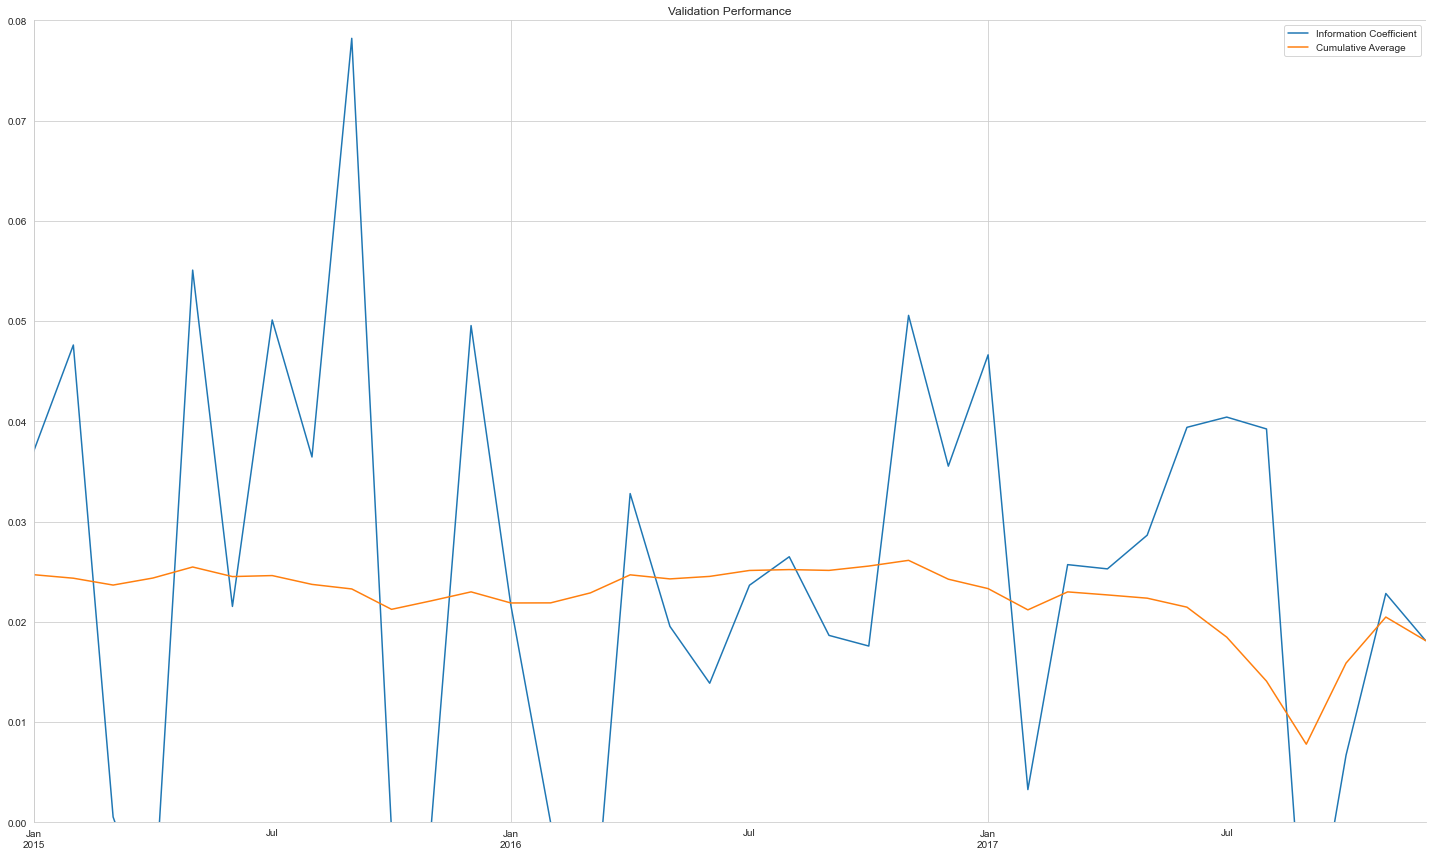

In [18]:
# Evaluate Results
metrics = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
ax = metrics.IC.plot(figsize=(20, 12), label='Information Coefficient', title='Validation Performance',
                    ylim=(0, .08))
metrics.IC.expanding().mean().plot(ax=ax, label='Cumulative Average')
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'cnn_ts1d_ic', dpi=300);